This notebook explores use of an RNN with the [EEG eye state dataset](https://archive.ics.uci.edu/ml/datasets/EEG+Eye+State).
> All data is from one continuous EEG measurement with the Emotiv EEG Neuroheadset. The duration of the measurement was 117 seconds. The eye state was detected via a camera during the EEG measurement and added later manually to the file after analysing the video frames. '1' indicates the eye-closed and '0' the eye-open state. All values are in chronological order with the first measured value at the top of the data.

As the data is provided in chronological order we can generate labeled sequences suitable for training an RNN.  We'll start by loading the data:

In [14]:
import numpy as np

# Load data file
# There are 19 rows of "header" material in our data file
rawdata = np.loadtxt('EEG_eye_state.txt', delimiter=',', skiprows=19, dtype=np.float32)

# Separate into X inputs and y labels
X_raw = rawdata[:,:-1]
y_raw = rawdata[:,-1]
print('Input consists of {} samples with {} dimensions.  Two samples follow:'.format(X_raw.shape[0], X_raw.shape[1]))
print(X_raw[:2])

Input consists of 14980 samples with 14 dimensions.  Two samples follow:
[[4329.23 4009.23 4289.23 4148.21 4350.26 4586.15 4096.92 4641.03 4222.05
  4238.46 4211.28 4280.51 4635.9  4393.85]
 [4324.62 4004.62 4293.85 4148.72 4342.05 4586.67 4097.44 4638.97 4210.77
  4226.67 4207.69 4279.49 4632.82 4384.1 ]]


Each sample consists of 14 features which are high value numbers which little change through the samples.   These changes are quite small objectively so, to accentuate the patterns present in the miniscule variations in the data we'll need to do some pre-processing so the variations become more pronounced and easier for our model to train on:

In [35]:
from sklearn.preprocessing import normalize, scale, robust_scale

# normalizing first, then scaling (not the reverse) has a significant effect in the ability for the model to train
X_raw = normalize(X_raw, axis=0)
# robust scales drastically improves training time
X_raw = robust_scale(X_raw, axis=0) #scale(X_raw, axis=0)

print('After scaling and normalizing the data:')
print(X_raw[:2])

After scaling and normalizing the data:
[[ 1.1147691   0.11111268  1.3003129   1.1493949   0.73356706 -2.137121
   1.0397837   1.4219768   1.2220811   0.48629     0.5123863   0.18418221
   1.2305937   1.2668048 ]
 [ 0.9673944  -0.03156257  1.5255711   1.1705632   0.20012219 -2.1021624
   1.0600665   1.3162531   0.6110405  -0.13486315  0.3415985   0.13187335
   1.1151031   0.9499366 ]]


Now that our data has been pre-processed we need to convert the chronological list of single EEG observations into samples that consist of **sequences** of EEG observations.   We'll choose a `window_size` which indicates the length of the EEG sequence we want in each sample.   We'll take the first `window_size` EEG observations and turn them into a sequence.  The label for this sequence will be the label that applies to the final  EEG observation in the sequence.  

Our next sample will start with the 2nd EEG observation from the previous sample and add one new EEG observation.  The label for this next sample will be the label of the new EEG observation (last in the sequence) added for this sample.  We end up with `window_size` *fewer* samples because the first `window_size` - 1 observations are present in the first sample's sequence.

In [36]:
# transform from single labeled EEG reading in to labeled *sequences* of EEG readings
def ordered_samples_to_sequence_samples(samples, labels, window_size):
    seq_labels = labels[window_size:]
    seq_samples = []
    for sample_idx in range(window_size, len(samples)):
        seq_samples.append(samples[sample_idx - window_size:sample_idx])
            
    return (np.array(seq_samples), np.array(seq_labels))
       
window_size = 10
X, y = ordered_samples_to_sequence_samples(X_raw, y_raw, window_size)

print(X.shape)


(14970, 10, 14)


Next we use the `train_test_split` function to divide into train and test datasets.

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.shape)


(11227, 10, 14)


In [45]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Activation
from keras import optimizers


# create and fit the LSTM network
model = Sequential()
model.add(GRU(196, dropout=0.2, recurrent_dropout=0.2, input_shape=X_train.shape[1:])) # input shape is the 2nd and 3rd dim of data
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam', # optimizers.Adam(lr=0.003)
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 196)               124068    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 197       
Total params: 124,265
Trainable params: 124,265
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
import os, datetime

# checkpoint
filepath="rnn-weights.hdf5" # "weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=2, save_best_only=True, mode='max')

# early stopping
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=2, mode='auto')

skip_training = False
if os.path.isfile(filepath) and skip_training:
    model = load_model(filepath)
    print("Loaded model created at {}".format(
            datetime.datetime.fromtimestamp(os.path.getmtime(filepath)).strftime('%Y-%m-%d %H:%M:%S')))
else:
    # train the model
    history = model.fit(X_train, 
                        y_train, 
                        validation_split=0.2, 
                        epochs=50, 
                        batch_size=32, 
                        verbose=2, 
                        callbacks=[checkpoint, early_stop])

Train on 8981 samples, validate on 2246 samples
Epoch 1/50
Epoch 00001: val_acc improved from -inf to 0.98397, saving model to rnn-weights.hdf5
 - 6s - loss: 0.1130 - acc: 0.9558 - val_loss: 0.0394 - val_acc: 0.9840
Epoch 2/50
Epoch 00002: val_acc improved from 0.98397 to 0.99065, saving model to rnn-weights.hdf5
 - 6s - loss: 0.0998 - acc: 0.9615 - val_loss: 0.0259 - val_acc: 0.9907
Epoch 3/50
Epoch 00003: val_acc improved from 0.99065 to 0.99288, saving model to rnn-weights.hdf5
 - 6s - loss: 0.1097 - acc: 0.9564 - val_loss: 0.0271 - val_acc: 0.9929
Epoch 4/50
Epoch 00004: val_acc did not improve
 - 6s - loss: 0.0933 - acc: 0.9621 - val_loss: 0.0264 - val_acc: 0.9929
Epoch 5/50
Epoch 00005: val_acc did not improve
 - 6s - loss: 0.0938 - acc: 0.9655 - val_loss: 0.0279 - val_acc: 0.9915
Epoch 6/50
Epoch 00006: val_acc improved from 0.99288 to 0.99377, saving model to rnn-weights.hdf5
 - 6s - loss: 0.0985 - acc: 0.9623 - val_loss: 0.0266 - val_acc: 0.9938
Epoch 7/50
Epoch 00007: val_acc

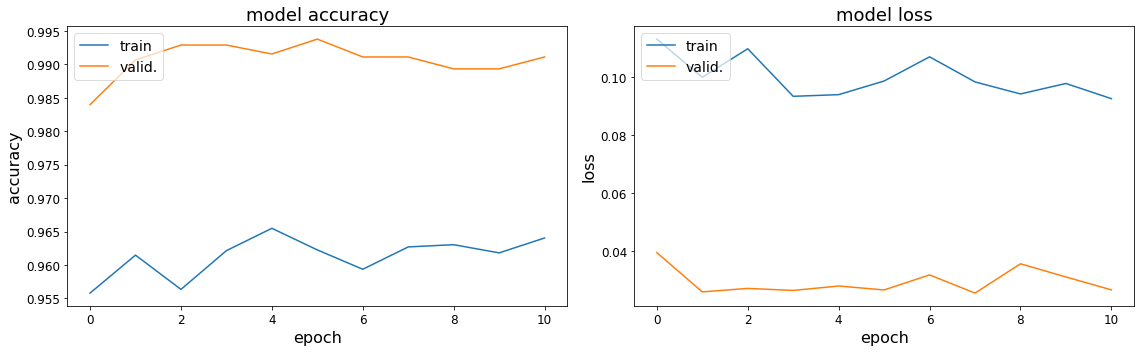

In [49]:
%matplotlib inline
import plot_util as plots

plots.plot_history(history)

In [50]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

3743/3743 [==============================] - 1s 216us/step
Test score: 0.02903972286009435
Test accuracy: 0.9893133849853059


In [ ]:
TODO: setup callbacks - https://keras.io/callbacks/